la définition de la fonction unpickle qui prend le chemin du fichier et qui retourne le dictionnaire qui contient 4 clès

In [ ]:
#la définition de la fonction unpickle
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
file='C:/Users/elmai/Downloads/data/data_batch_1'

In [ ]:
data=unpickle(file)

In [ ]:
#affichages des clé du dictionnaire
data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [ ]:
data[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [ ]:
import numpy as np
#la definition de la fonction read_cifar_batch pour lire un seul batch
def read_cifar_batch(file,k=0):
  batch=unpickle(file)
  if k==0:
    return batch[b'data']
  if k==1:
    return np.array(batch[b'labels'])

In [ ]:
#la définition de la fonction read_cifar qui va lire toutes les data_batch et le test_batch
from os import walk

def read_cifar(path,k=0):
  filenames = next(walk(path), (None, None, []))[2]
  p1=path+'/'+filenames[0]
  p2=path+'/'+filenames[1]
  p3=path+'/'+filenames[2]
  p4=path+'/'+filenames[3]
  p5=path+'/'+filenames[4]
  p6=path+'/'+filenames[5]

  data1=read_cifar_batch(p1,k=0)
  data2=read_cifar_batch(p2,k=0)
  data3=read_cifar_batch(p3,k=0)
  data4=read_cifar_batch(p4,k=0)
  data5=read_cifar_batch(p5,k=0)
  data6=read_cifar_batch(p6,k=0)
  concate1=np.concatenate((data1,data2,data3))
  concate2=np.concatenate((data4,data5,data6))
  concate=np.concatenate((concate1,concate2))

  label1=read_cifar_batch(p1,k=1)
  label2=read_cifar_batch(p2,k=1)
  label3=read_cifar_batch(p3,k=1)
  label4=read_cifar_batch(p4,k=1)
  label5=read_cifar_batch(p5,k=1)
  label6=read_cifar_batch(p6,k=1)
  lb1=np.concatenate((label1,label2,label3))
  lb2=np.concatenate((label4,label5,label6))
  lb=np.concatenate((lb1,lb2))

  if k==0:
    return concate
  if k==1:
    return lb

In [ ]:
#la defintion de la fonction split_dataset
from numpy.random import PCG64
import numpy as np
from sklearn.model_selection import train_test_split
def split_dataset(data,label,split,k=0):
  data_train, data_test, labels_train, labels_test = train_test_split(data,label, test_size=split, random_state=42)
  if k==0:
    return data_train
  if k==1:
    return data_test
  if k==2:
    return labels_train
  if k==3:
    return labels_test


On va tester la fonction split_dataset sur une seule batch avec la repartirion de la partie d'entrainement et de test en 80% et 20%

In [ ]:
# on va appliquer la fonction split sur une seule batch
data_train_batch=split_dataset(read_cifar_batch(file,0),read_cifar_batch(file,1),0.2,0)
data_test_batch=split_dataset(read_cifar_batch(file,0),read_cifar_batch(file,1),0.2,1)
labels_train_batch=split_dataset(read_cifar_batch(file,0),read_cifar_batch(file,1),0.2,2)
labels_test_batch=split_dataset(read_cifar_batch(file,0),read_cifar_batch(file,1),0.2,3)

la verification des dimension de la data_test et data_train

In [ ]:
x,y=data_test_batch.shape,data_train_batch.shape
x,y

((2000, 3072), (8000, 3072))

Mainteneant on va appliquer la fonction split_dataset sur tout le data_set en appelant la methode read_ciraf avec une répartition de 10% 90%

In [ ]:
path='C:/Users/elmai/Downloads/data'
data_train=split_dataset(read_cifar(path,0),read_cifar(path,1),0.1,0)
data_test=split_dataset(read_cifar(path,0),read_cifar(path,1),0.1,1)
labels_train=split_dataset(read_cifar(path,0),read_cifar(path,1),0.1,2)
labels_test=split_dataset(read_cifar(path,0),read_cifar(path,1),0.1,3)

la verification des dimension de la data_test et data_train

In [ ]:
x,y=data_test.shape,data_train.shape
print(x,y)

(6000, 3072) (54000, 3072)


Dans cette partie on va définir la fonction distance matricielle

In [ ]:
# Premièrment on va définir la focntion dist_matrix_batch qui calcule juste la distance entre 2 vecteur
def dist_matrix_batch(a,b):
  return np.dot(a,a.transpose())+np.dot(b,b.transpose())-2*np.dot(a,b.transpose())

la fonction dist_matrix calcule la distance matricielle

In [ ]:
from scipy.optimize.slsqp import concatenate
def dist_matrix(data_train,data_test):
  concate=dist_matrix_batch(data_train[:data_test.shape[0]],data_test)
  l=int(data_train.shape[0]/data_test.shape[0])
  for i in range(1,l):
    m=dist_matrix_batch(data_train[data_test.shape[0]*i:data_test.shape[0]*(i+1)],data_test)
    concate=np.concatenate((concate,m),axis=1)
  return concate

Le précedent algorithme de calcule de la distance matricielle necessite un temps d'exécution très lent sur toute le data_set qui peut durer plusieurs heures, c'est pour cela j'ai choisie de l'appliquer sur un seule batch

In [ ]:
l=dist_matrix(data_train_batch,data_test_batch)


In [ ]:
l.shape

(2000, 8000)

On va définir la fonction most_frequent qui va retourner l'élement le plus fréquenté dans une liste , que l'on va utiliser oar suite pour prédir la classe associé à un élément dans un nuage de k point.

In [ ]:
def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

Dans cette etape on va créer la fonction predict-knn qui va retourner les labels du test set

In [ ]:
def knn_predict(dists,label_train,k):
  pred=[]
  for i in range(dists.shape[0]):

    m=sorted(range(len(dists[i,:])), key = lambda sub: dists[i,:][sub])[:k]
    pred.append(most_frequent(list(label_train[m])))
  return pred

On va calculer les valeurs prédites du data_test à l'aide de la fonction knn_predict pour un seul batch et avec une valeur de k=10

In [ ]:
valeur_predites=knn_predict(l,labels_train_batch,10)

In [ ]:
len(valeur_predites)

2000

In [ ]:
#affichage des valeurs prédites
valeur_predites

[7,
 2,
 8,
 8,
 0,
 2,
 5,
 5,
 2,
 8,
 0,
 3,
 6,
 8,
 6,
 8,
 8,
 6,
 6,
 9,
 5,
 5,
 8,
 2,
 1,
 4,
 8,
 0,
 3,
 6,
 5,
 5,
 7,
 4,
 7,
 6,
 4,
 0,
 2,
 2,
 4,
 2,
 2,
 8,
 6,
 1,
 3,
 2,
 8,
 5,
 0,
 8,
 4,
 0,
 6,
 5,
 3,
 7,
 9,
 9,
 5,
 7,
 4,
 5,
 4,
 2,
 2,
 5,
 1,
 6,
 8,
 6,
 4,
 1,
 3,
 9,
 2,
 4,
 6,
 4,
 3,
 2,
 9,
 9,
 1,
 9,
 2,
 5,
 5,
 4,
 2,
 4,
 4,
 5,
 6,
 5,
 9,
 8,
 8,
 9,
 8,
 5,
 0,
 1,
 5,
 7,
 5,
 5,
 1,
 3,
 4,
 5,
 0,
 6,
 0,
 9,
 2,
 1,
 0,
 5,
 1,
 2,
 0,
 1,
 1,
 2,
 4,
 1,
 5,
 8,
 7,
 9,
 0,
 9,
 0,
 0,
 7,
 4,
 9,
 3,
 9,
 2,
 3,
 8,
 3,
 7,
 0,
 1,
 0,
 9,
 9,
 4,
 8,
 6,
 5,
 5,
 4,
 2,
 2,
 4,
 7,
 2,
 8,
 0,
 0,
 6,
 9,
 1,
 3,
 3,
 5,
 0,
 8,
 0,
 4,
 0,
 2,
 6,
 3,
 2,
 1,
 8,
 7,
 0,
 6,
 4,
 2,
 1,
 3,
 0,
 1,
 2,
 7,
 4,
 0,
 0,
 2,
 2,
 8,
 7,
 5,
 1,
 4,
 3,
 4,
 9,
 7,
 5,
 9,
 4,
 8,
 2,
 2,
 9,
 8,
 2,
 2,
 5,
 1,
 0,
 6,
 6,
 1,
 5,
 0,
 4,
 2,
 9,
 2,
 9,
 9,
 0,
 3,
 3,
 8,
 4,
 7,
 7,
 3,
 9,
 3,
 5,
 3,
 0,
 6,
 6,
 6,
 0,
 0,
 0,


In [ ]:
#calcule de l'accuracy pour cette exemple
r=list(labels_test_batch)
ac=0
for i in range(labels_test_batch.shape[0]):
  if(r[i]==valeur_predites[i]):
    ac+=1
  
print(ac/len(r))

0.1065


On remarque que l'accuracy est faible ne dépasse pas 10%

Création de la fonction evaluate_knn qui prend comme paramètres data_train,label_train,data_test,label_test,k et qui retourne l'accuracy

In [ ]:
def evaluate_knn(data_train,label_train,data_test,label_test,k):
  dist=dist_matrix(data_train,data_test)
  knn_predict(dist,label_train,k)
  r=list(label_test)
  ac=0
  for i in range(label_test.shape[0]):
    if(r[i]==valeur_predites[i]):
      ac+=1
  return(ac/len(r))

On va appliquer la fonction evaluaate knn sur notre batch , puis on va créer une liste qui contient la variantion d'accuracy en fonction de k

In [ ]:
all_eval=[]
for i in range(10,20,1):
  eval=evaluate_knn(data_train_batch,labels_train_batch,data_test,labels_test_batch,i)
  all_eval.append(eval)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_eval)

On va utiliser une deuxième méthode qui est basé sur la definition de modèle dans une classe

In [ ]:
class KNN_model(object):
    #definir le constructeur de la classe
    def __init__(self):
        pass
    # définir l'entranement de la classe 
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Valeur invalide %d pour num_loops' % num_loops)
        return self.predict_labels(dists, k=k)
    #calcule de la distance euclidienne
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists
    #prédiction 
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred

In [ ]:
num_test= labels_test.shape[0]
classifier = KNN_model()
classifier.train(data_train, labels_train)
dists= classifier.compute_distances(data_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == labels_test)
accuracy = float(num_correct) / num_test
print('On a %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

On a 3996 / 12000 correct => accuracy: 0.333000


In [ ]:

print('Train data shape: ', data_train.shape)
print('Train labels shape: ', labels_train.shape)
print('Test data shape: ', data_test.shape)
print('Test labels shape: ', labels_test.shape)

Train data shape:  (54000, 3072)
Train labels shape:  (54000,)
Test data shape:  (6000, 3072)
Test labels shape:  (6000,)


In [ ]:
k_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
k_to_accuracies = {}
for k in k_choices:
    num_test=y_test.shape[0] 
    k_to_accuracies[k] = []
    X_test = data_test
    y_test = labels_test
    X_train = data_train
    y_train = labels_train
    classifier = KNN_model()
    classifier.train(X_train, y_train)
    dists = classifier.compute_distances(X_test)
    y_test_pred = classifier.predict_labels(dists, k)
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    k_to_accuracies[k].append(accuracy)
print("Ecrire notre accuracy pour différentes valeurs de k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Ecrire notre accuracy pour différentes valeurs de k:

k = 1, accuracy = 0.361500
k = 2, accuracy = 0.320500
k = 3, accuracy = 0.339333
k = 4, accuracy = 0.339167
k = 5, accuracy = 0.339000
k = 6, accuracy = 0.338833
k = 7, accuracy = 0.339833
k = 8, accuracy = 0.338167
k = 9, accuracy = 0.336333
k = 10, accuracy = 0.332000
k = 11, accuracy = 0.329333
k = 12, accuracy = 0.330667
k = 14, accuracy = 0.330667
k = 15, accuracy = 0.330333
k = 16, accuracy = 0.328000
k = 17, accuracy = 0.326500
k = 18, accuracy = 0.326667
k = 19, accuracy = 0.325333
k = 20, accuracy = 0.324000


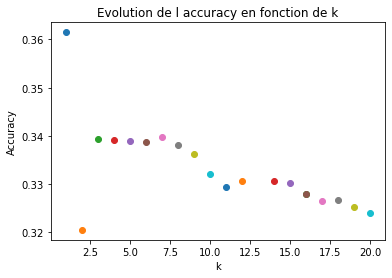

<function matplotlib.pyplot.close(fig=None)>

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

plt.title('Evolution de l accuracy en fonction de k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('knn.png')
plt.close 